In [1]:
!git clone https://github.com/WongKinYiu/yolov7
%cd yolov7
!pip install -r requirements.txt


Cloning into 'yolov7'...
remote: Enumerating objects: 1197, done.
remote: Total 1197 (delta 0), reused 0 (delta 0), pack-reused 1197 (from 1)
Receiving objects: 100% (1197/1197), 74.23 MiB | 16.39 MiB/s, done.
Resolving deltas: 100% (519/519), done.
/content/yolov7
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 79.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 58.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 51.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 40.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d biancaferreira/african-wildlife

!unzip -q african-wildlife.zip -d /content/african_wildlife


Dataset URL: https://www.kaggle.com/datasets/biancaferreira/african-wildlife
License(s): unknown


In [29]:
from pathlib import Path
import shutil

source_dir = Path("/content/african_wildlife")
flat_img = source_dir / "images"
flat_lbl = source_dir / "labels"
flat_img.mkdir(exist_ok=True)
flat_lbl.mkdir(exist_ok=True)

for cls_dir in source_dir.iterdir():
    if cls_dir.is_dir() and cls_dir.name not in ["images", "labels"]:
        for img_file in cls_dir.glob("*.jpg"):
            dst_img = flat_img / img_file.name
            if not dst_img.exists():
                shutil.copy(img_file, dst_img)
            lbl_file = cls_dir / f"{img_file.stem}.txt"
            dst_lbl = flat_lbl / lbl_file.name
            if lbl_file.exists() and not dst_lbl.exists():
                shutil.copy(lbl_file, dst_lbl)


In [30]:
import random

img_dir = Path("/content/african_wildlife/images")
lbl_dir = Path("/content/african_wildlife/labels")
yolo_data_dir = Path("data/african_wildlife")

for split in ["train", "val"]:
    (yolo_data_dir / f"images/{split}").mkdir(parents=True, exist_ok=True)
    (yolo_data_dir / f"labels/{split}").mkdir(parents=True, exist_ok=True)

for p in yolo_data_dir.glob("*/*/*"):
    for f in p.glob("*"):
        f.unlink()

all_imgs = [f for f in img_dir.glob("*.jpg") if (lbl_dir / f"{f.stem}.txt").exists()]
random.seed(42)
random.shuffle(all_imgs)
split_idx = int(0.8 * len(all_imgs))
train_imgs = all_imgs[:split_idx]
val_imgs = all_imgs[split_idx:]

def copy_pairs(images, img_out, lbl_out):
    for img in images:
        lbl = lbl_dir / f"{img.stem}.txt"
        shutil.copy(img, img_out / img.name)
        shutil.copy(lbl, lbl_out / lbl.name)

copy_pairs(train_imgs, yolo_data_dir / "images/train", yolo_data_dir / "labels/train")
copy_pairs(val_imgs, yolo_data_dir / "images/val", yolo_data_dir / "labels/val")


In [31]:
yaml_content = """
train: data/african_wildlife/images/train
val: data/african_wildlife/images/val

nc: 4
names: ['buffalo', 'elephant', 'rhino', 'zebra']
"""

with open("data/african_wildlife.yaml", "w") as f:
    f.write(yaml_content)


In [32]:
!sed -i 's/torch.load(weights, map_location=device)/torch.load(weights, map_location=device, weights_only=False)/' train.py

import os
os.environ["WANDB_MODE"] = "disabled"

!pip uninstall -y jax jaxlib tensorflow
!pip install tensorboardX
!sed -i 's/from torch.utils.tensorboard import SummaryWriter/from tensorboardX import SummaryWriter/' train.py


In [33]:
import shutil, random
from pathlib import Path

dataset_root = Path("/content/african_wildlife")

img_flat = dataset_root / "images"
lbl_flat = dataset_root / "labels"
img_flat.mkdir(exist_ok=True)
lbl_flat.mkdir(exist_ok=True)

for class_dir in dataset_root.iterdir():
    if class_dir.is_dir() and class_dir.name not in ['images', 'labels']:
        for img in class_dir.glob("*.jpg"):
            shutil.copy(img, img_flat / img.name)
            lbl = class_dir / f"{img.stem}.txt"
            if lbl.exists():
                shutil.copy(lbl, lbl_flat / lbl.name)


In [34]:
base = Path("data/african_wildlife")
for s in ['images/train', 'images/val', 'labels/train', 'labels/val']:
    p = base / s
    p.mkdir(parents=True, exist_ok=True)
    for f in p.glob("*"):
        f.unlink()

images = [f for f in img_flat.glob("*.jpg") if (lbl_flat / f"{f.stem}.txt").exists()]
random.shuffle(images)
split = int(0.8 * len(images))
train_imgs = images[:split]
val_imgs = images[split:]

def copy_pairs(imgs, img_out, lbl_out):
    for img in imgs:
        lbl = lbl_flat / f"{img.stem}.txt"
        shutil.copy(img, img_out / img.name)
        shutil.copy(lbl, lbl_out / lbl.name)

copy_pairs(train_imgs, base / "images/train", base / "labels/train")
copy_pairs(val_imgs, base / "images/val", base / "labels/val")


In [35]:
%cd /content/yolov7

/content/yolov7


In [11]:
!pip install tensorboard


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 56.5 MB/s eta 0:00:00


In [13]:
%cd /content/yolov7

/content/yolov7


In [36]:
yaml_content = """
train: data/african_wildlife/images/train
val: data/african_wildlife/images/val

nc: 4
names: ['buffalo', 'elephant', 'rhino', 'zebra']
"""

with open('data/african_wildlife.yaml', 'w') as f:
    f.write(yaml_content)




In [27]:
import torch
import torch.serialization
from models.yolo import Model

torch.serialization.add_safe_globals({'Model': Model})


In [37]:
%cd /content/yolov7

!python train.py --weights yolov7.pt --cfg cfg/training/yolov7.yaml \
  --data data/african_wildlife.yaml \
  --hyp data/hyp.scratch.custom.yaml \
  --epochs 50 --batch-size 16 --img 640 640 \
  --project runs/train --name wildlife_yolov7 --exist-ok


/content/yolov7
YOLOR 🚀 v0.1-128-ga207844 torch 2.6.0+cu124 CUDA:0 (Tesla T4, 15095.0625MB)

Namespace(weights='yolov7.pt', cfg='cfg/training/yolov7.yaml', data='data/african_wildlife.yaml', hyp='data/hyp.scratch.custom.yaml', epochs=50, batch_size=16, img_size=[640, 640], rect=False, resume=False, nosave=False, notest=False, noautoanchor=False, evolve=False, bucket='', cache_images=False, image_weights=False, device='', multi_scale=False, single_cls=False, adam=False, sync_bn=False, local_rank=-1, workers=8, project='runs/train', entity=None, name='wildlife_yolov7', exist_ok=True, quad=False, linear_lr=False, label_smoothing=0.0, upload_dataset=False, bbox_interval=-1, save_period=-1, artifact_alias='latest', freeze=[0], v5_metric=False, world_size=1, global_rank=-1, save_dir='runs/train/wildlife_yolov7', total_batch_size=16)
tensorboard: Start with 'tensorboard --logdir runs/train', view at http://localhost:6006/
hyperparameters: lr0=0.01, lrf=0.1, momentum=0.937, weight_decay=0.0005

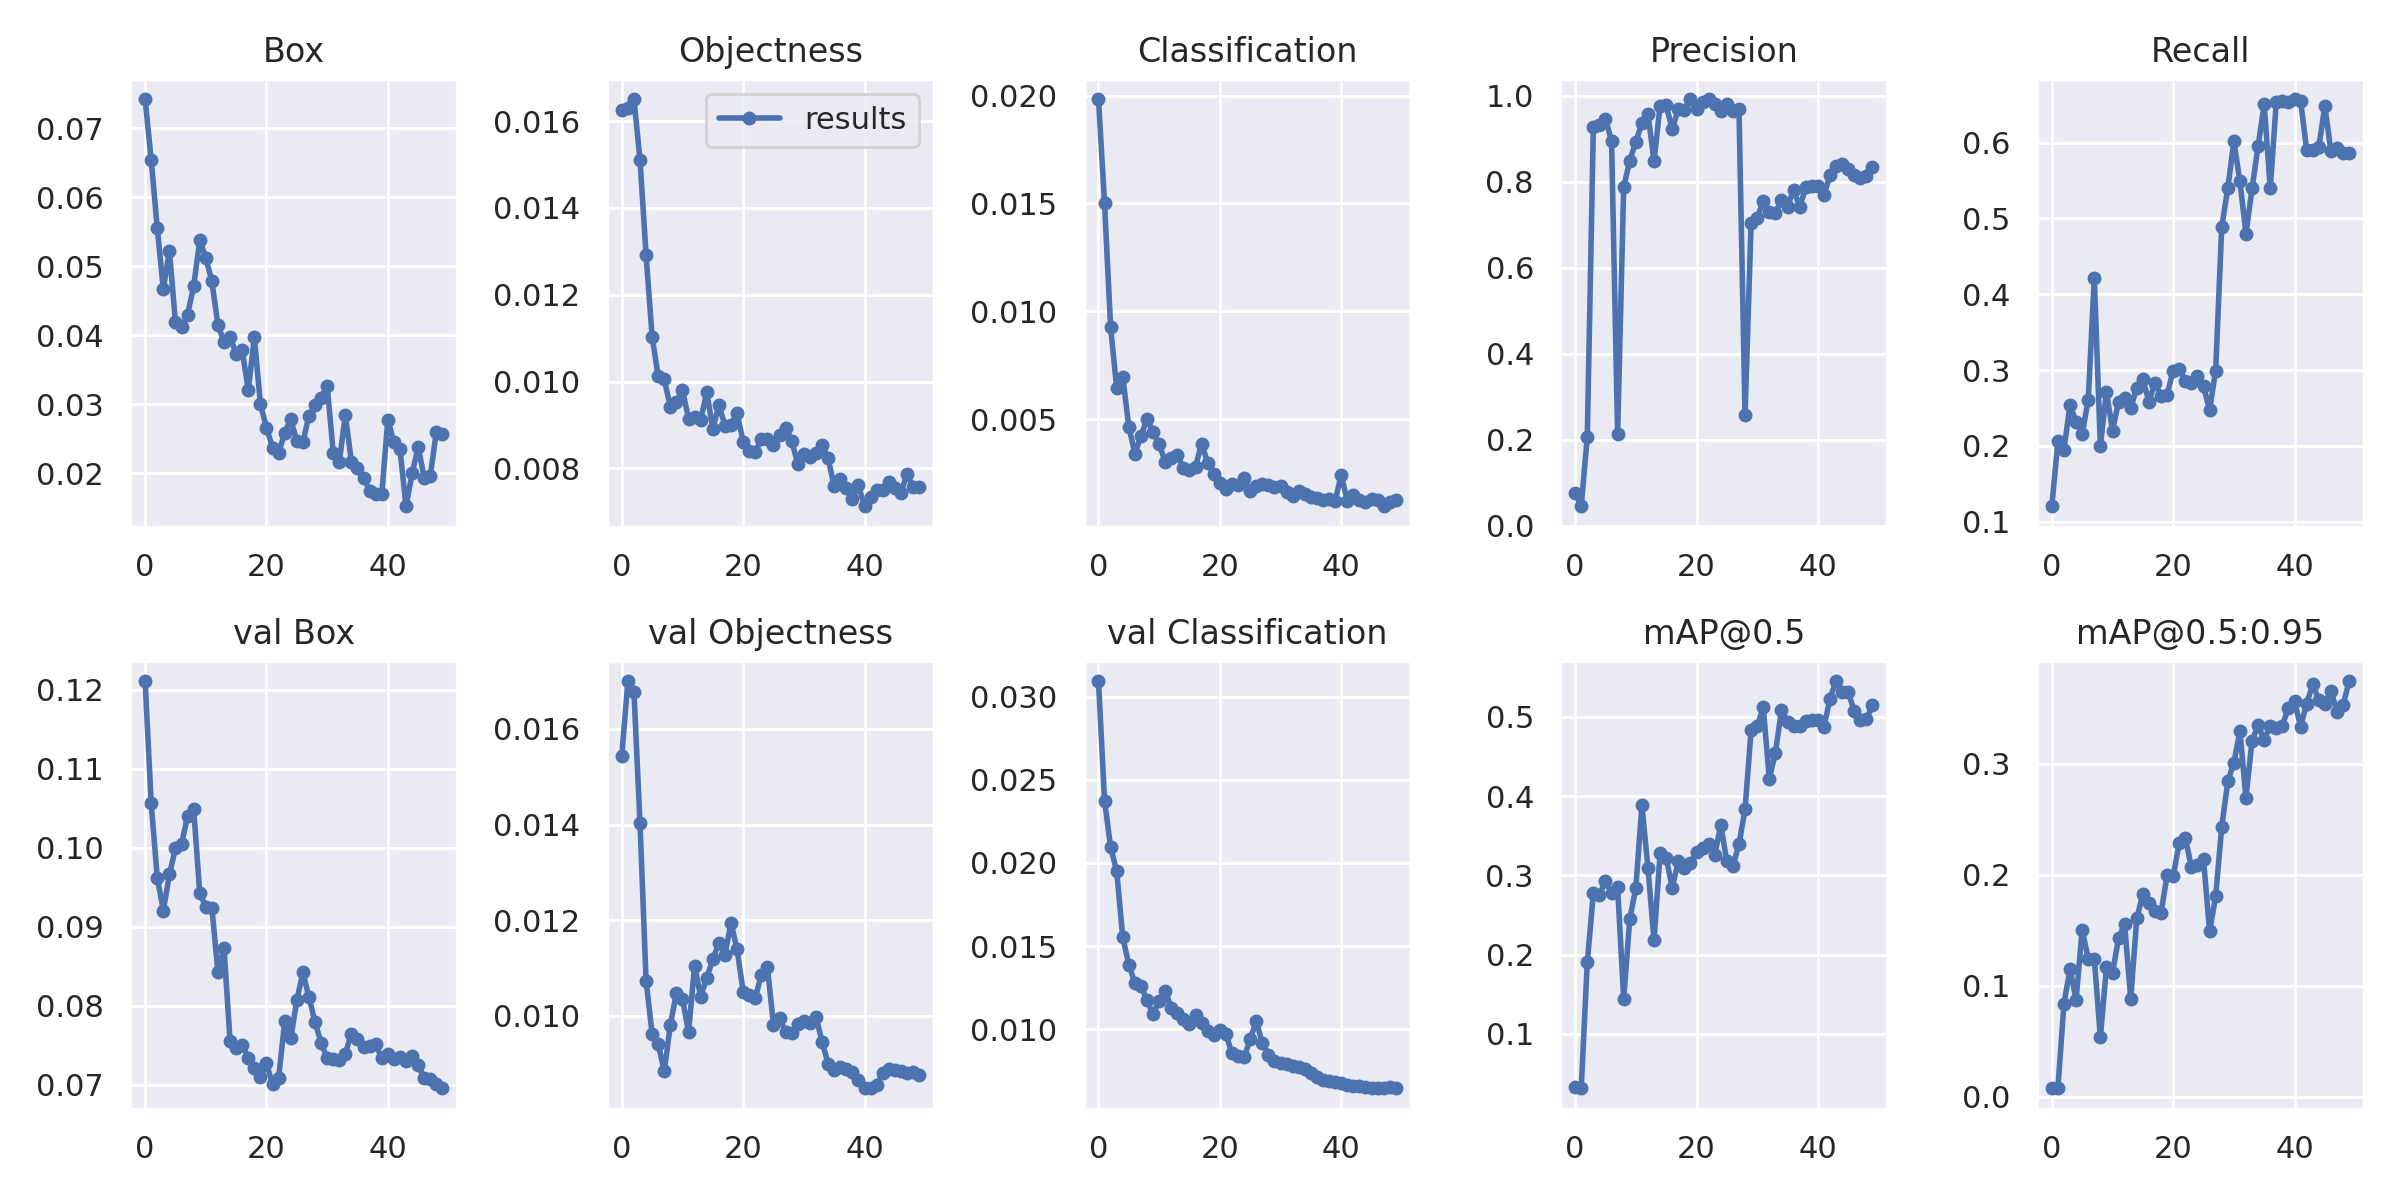

In [38]:
from IPython.display import Image, display
display(Image(filename='runs/train/wildlife_yolov7/results.png'))


In [50]:
!rm data/african_wildlife/labels/val.cache
!rm data/african_wildlife/labels/train.cache



rm: cannot remove 'data/african_wildlife/labels/val.cache': No such file or directory
rm: cannot remove 'data/african_wildlife/labels/train.cache': No such file or directory


In [53]:
file_path = '/content/yolov7/models/experimental.py'
!sed -i "s/torch.load(w, map_location=map_location)/torch.load(w, map_location=map_location, weights_only=False)/g" {file_path}

In [54]:
!python test.py --weights runs/train/wildlife_yolov7/weights/best.pt \
  --data data/african_wildlife.yaml \
  --batch-size 16 --img-size 640 \
  --conf-thres 0.001 --iou-thres 0.45 \
  --task val --device 0 \
  --save-txt --save-conf \
  --project runs/test --name wildlife_eval_fixed --exist-ok

Namespace(weights=['runs/train/wildlife_yolov7/weights/best.pt'], data='data/african_wildlife.yaml', batch_size=16, img_size=640, conf_thres=0.001, iou_thres=0.45, task='val', device='0', single_cls=False, augment=False, verbose=False, save_txt=True, save_hybrid=False, save_conf=True, save_json=False, project='runs/test', name='wildlife_eval_fixed', exist_ok=True, no_trace=False, v5_metric=False)
YOLOR 🚀 v0.1-128-ga207844 torch 2.6.0+cu124 CUDA:0 (Tesla T4, 15095.0625MB)

Fusing layers... 
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
IDetect.fuse
/usr/local/lib/python3.11/dist-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3637.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Model Summary: 314 layers, 36497954 parameters, 6194944 gradients, 103.2 GFLOPS
 Convert model t

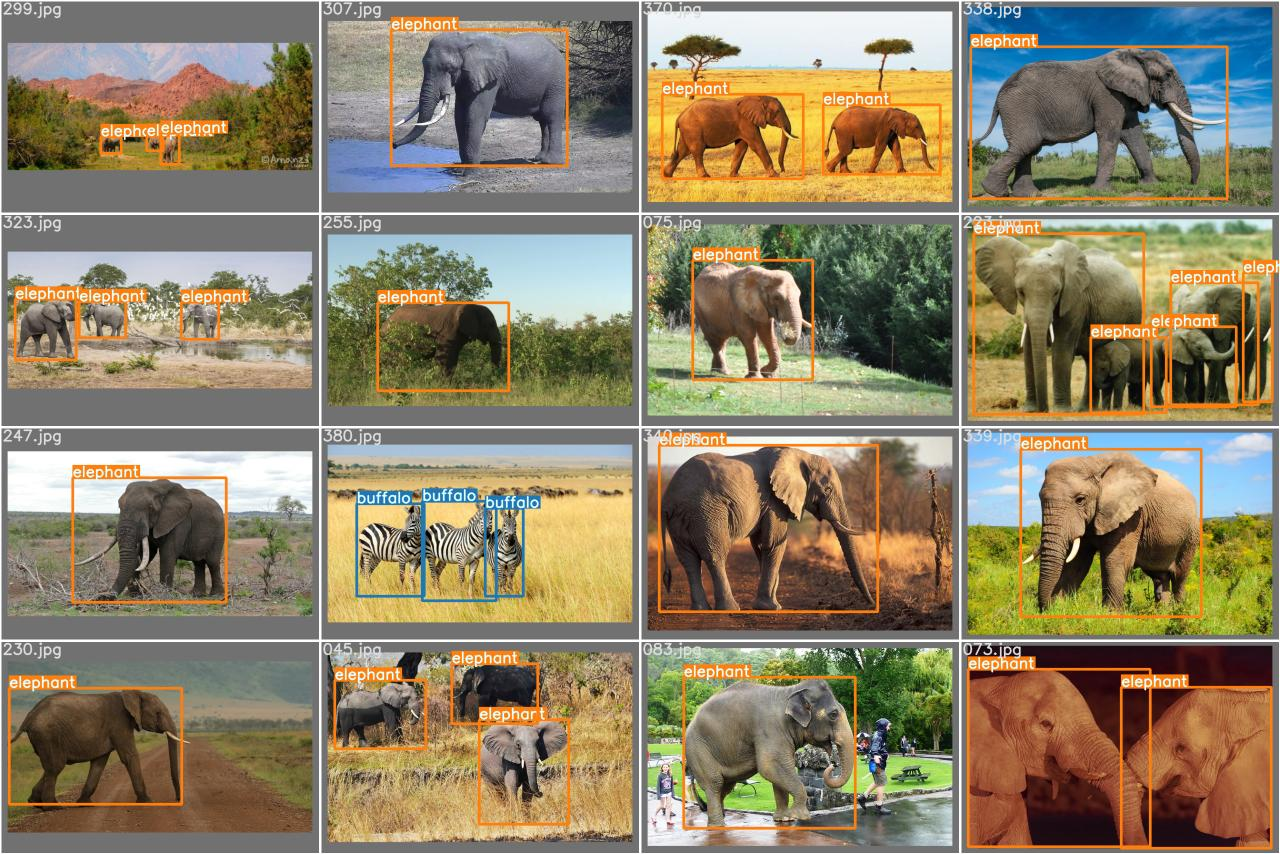

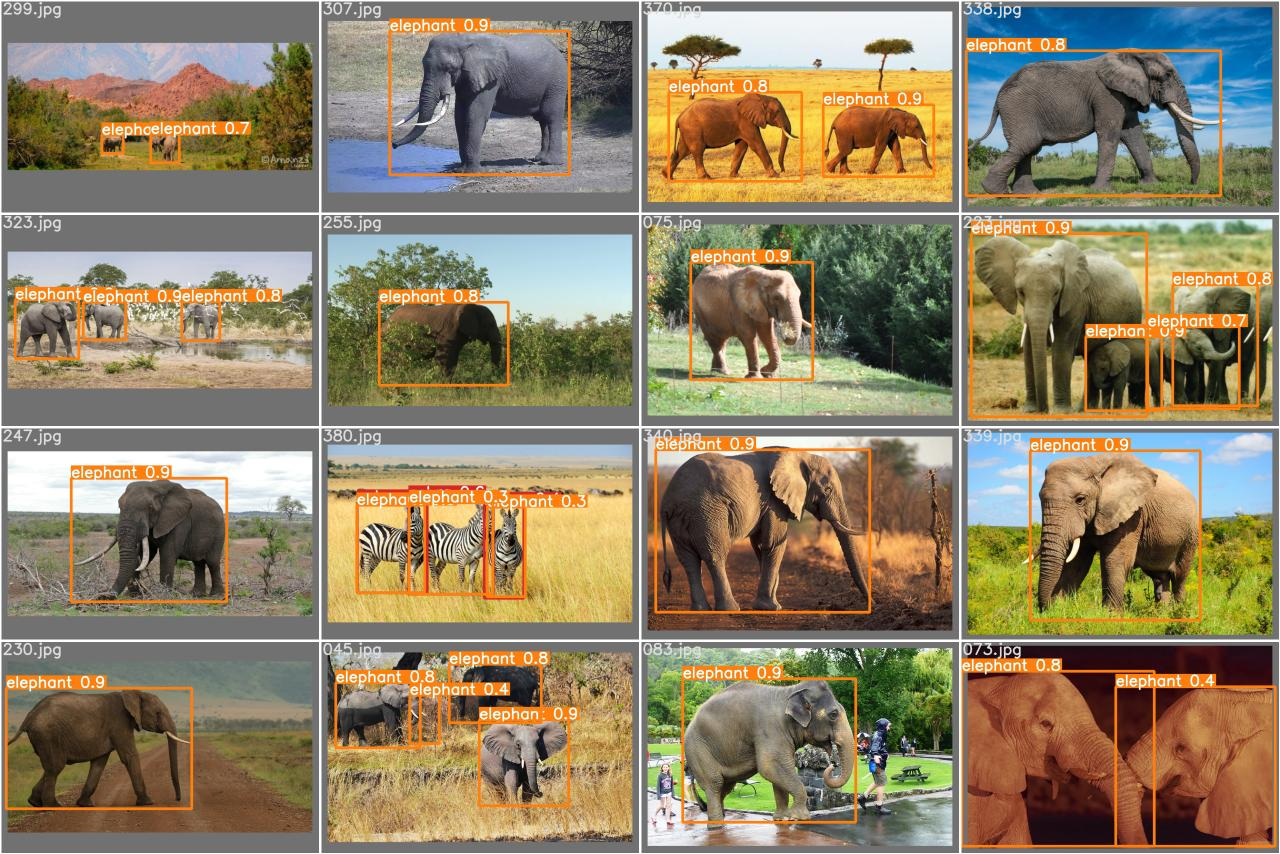

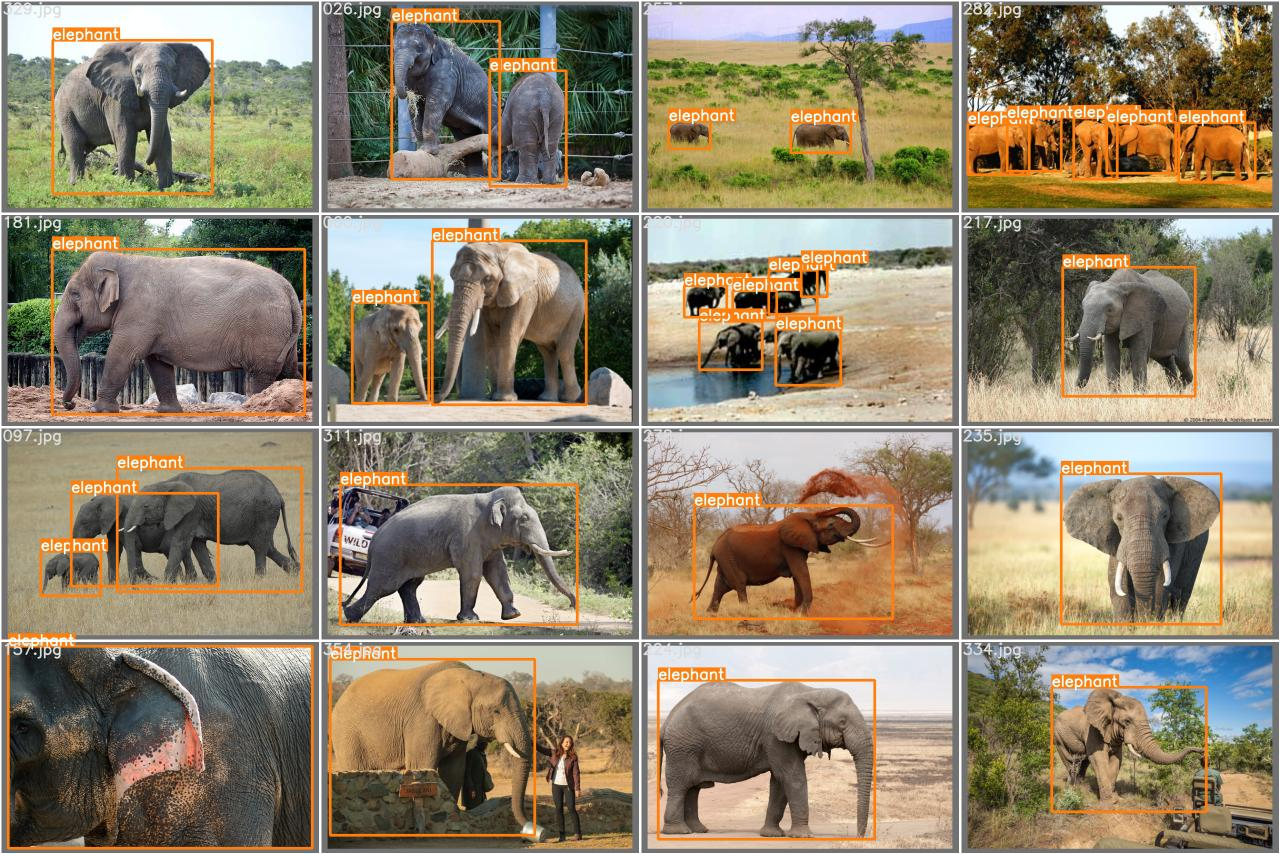

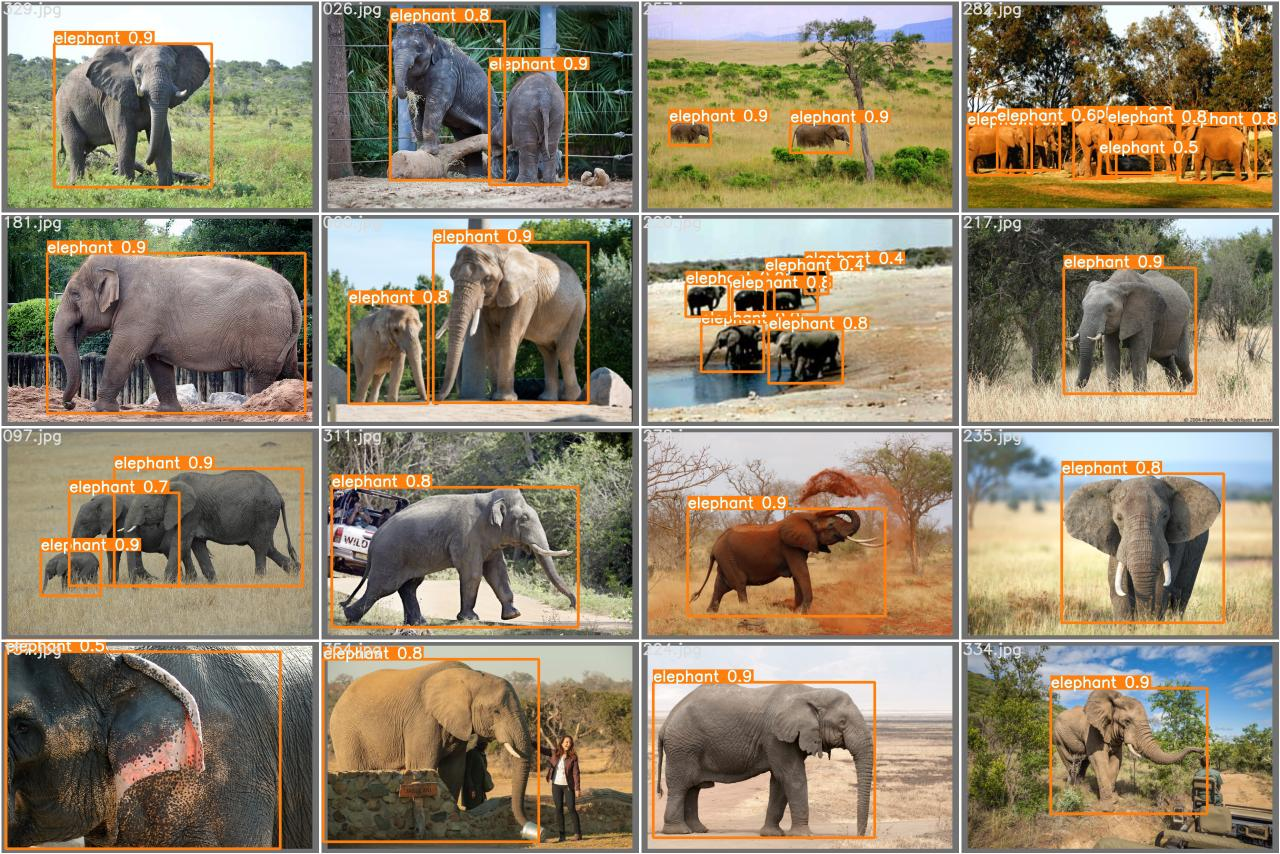

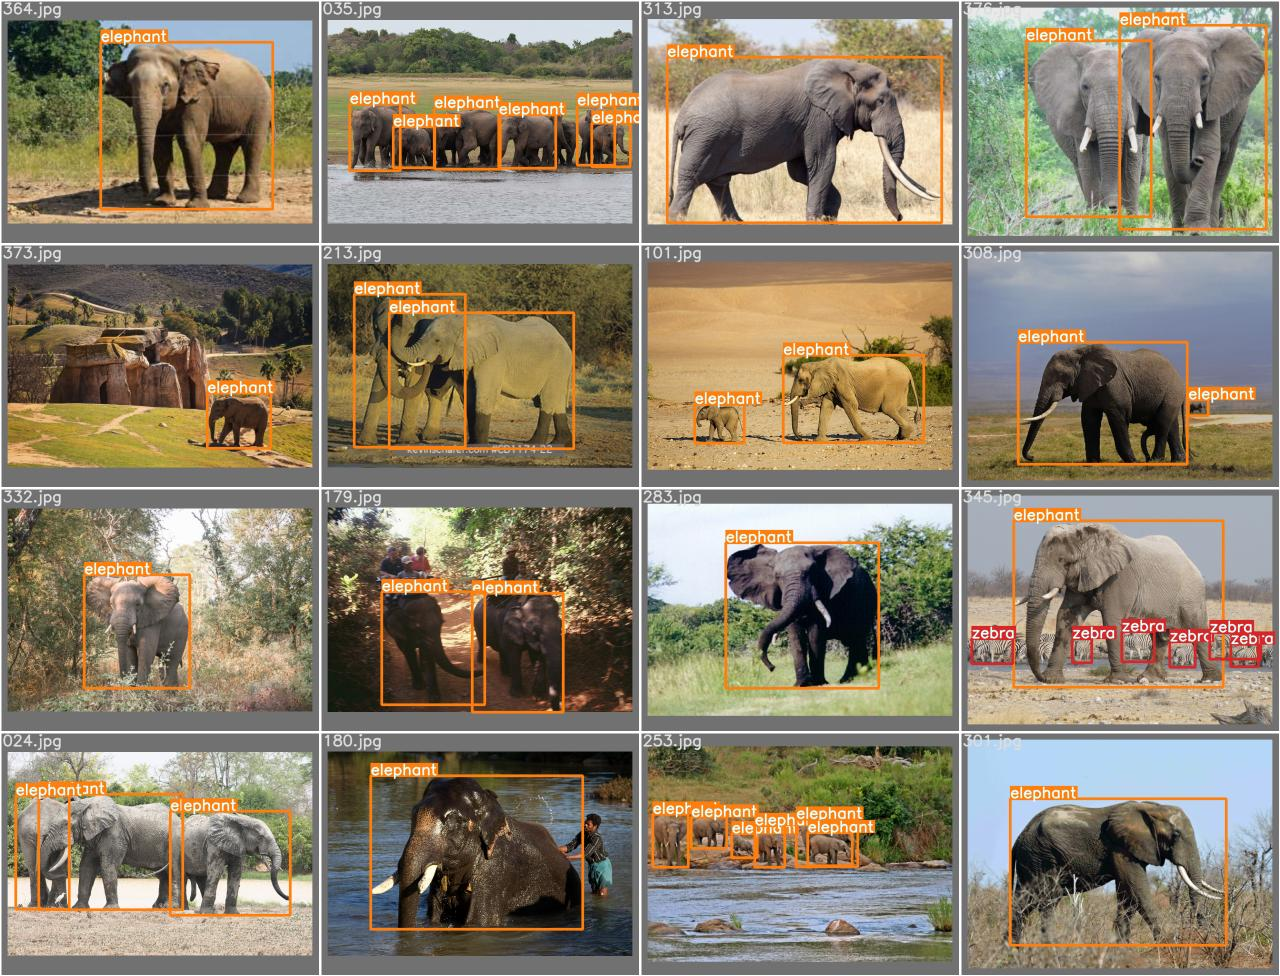

In [81]:
import glob
from IPython.display import Image, display

predicted_imgs = sorted(glob.glob('runs/test/wildlife_eval_fixed/*.jpg'))[:5]
for img_path in predicted_imgs:
    display(Image(filename=img_path, width=640))


In [82]:


import os
import cv2
from pathlib import Path
from torchvision import transforms
from PIL import Image as PILImage

src_dir = Path("data/african_wildlife/images/val")
dst_dir = Path("data/african_wildlife_modified/images/val")
dst_dir.mkdir(parents=True, exist_ok=True)


synthetic_transform = transforms.Compose([
    transforms.GaussianBlur(kernel_size=5, sigma=(0.5, 1.5)),
    transforms.ColorJitter(contrast=0.5),
])


for img_path in src_dir.glob("*.jpg"):
    img = PILImage.open(img_path).convert("RGB")
    transformed = synthetic_transform(img)
    transformed.save(dst_dir / img_path.name)





In [83]:
import shutil

src_labels = Path("data/african_wildlife/labels/val")
dst_labels = Path("data/african_wildlife_modified/labels/val")
dst_labels.mkdir(parents=True, exist_ok=True)

for lbl_path in src_labels.glob("*.txt"):
    shutil.copy(lbl_path, dst_labels / lbl_path.name)



In [85]:
yaml_content = """
train: data/african_wildlife/images/train
val: data/african_wildlife_modified/images/val

nc: 4
names: ['elephant', 'zebra', 'buffalo', 'rhino']
"""

with open("data/african_wildlife_modified.yaml", "w") as f:
    f.write(yaml_content)



In [86]:
!python test.py \
  --weights runs/train/wildlife_yolov7/weights/best.pt \
  --data data/african_wildlife_modified.yaml \
  --batch-size 16 \
  --img-size 640 \
  --conf-thres 0.001 \
  --iou-thres 0.45 \
  --task val \
  --save-txt \
  --save-conf \
  --project runs/test \
  --name wildlife_eval_modified \
  --exist-ok


Namespace(weights=['runs/train/wildlife_yolov7/weights/best.pt'], data='data/african_wildlife_modified.yaml', batch_size=16, img_size=640, conf_thres=0.001, iou_thres=0.45, task='val', device='', single_cls=False, augment=False, verbose=False, save_txt=True, save_hybrid=False, save_conf=True, save_json=False, project='runs/test', name='wildlife_eval_modified', exist_ok=True, no_trace=False, v5_metric=False)
YOLOR 🚀 v0.1-128-ga207844 torch 2.6.0+cu124 CUDA:0 (Tesla T4, 15095.0625MB)

Fusing layers... 
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
IDetect.fuse
/usr/local/lib/python3.11/dist-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3637.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Model Summary: 314 layers, 36497954 parameters, 6194944 gradients, 103.2 GFLOPS
 Conv

**Question1**

**Part a**

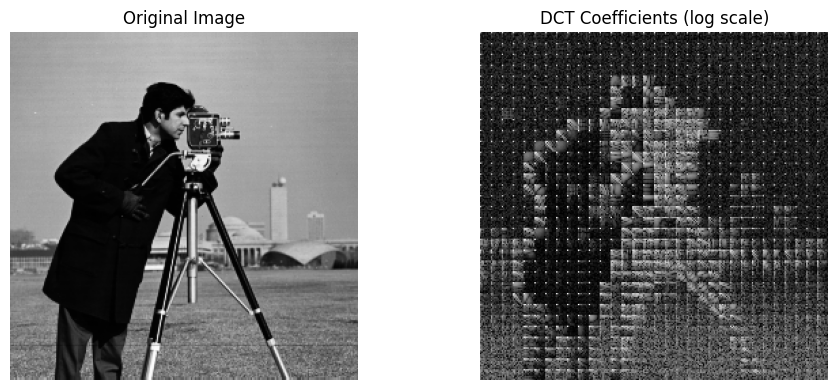

In [7]:
import numpy as np
import cv2
from scipy.fftpack import dct
import matplotlib.pyplot as plt

image = cv2.imread('cameraman.tif', cv2.IMREAD_GRAYSCALE)


height, width = image.shape
pad_height = (8 - height % 8) % 8
pad_width = (8 - width % 8) % 8
padded_image = np.pad(image, ((0, pad_height), (0, pad_width)), mode='constant', constant_values=0)

dct_transformed = np.zeros_like(padded_image, dtype=np.float32)

for i in range(0, padded_image.shape[0], 8):
    for j in range(0, padded_image.shape[1], 8):
        block = padded_image[i:i+8, j:j+8].astype(np.float32) - 128
        dct_block = dct(dct(block.T, norm='ortho').T, norm='ortho')
        dct_transformed[i:i+8, j:j+8] = dct_block

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(image, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("DCT Coefficients (log scale)")
plt.imshow(np.log1p(np.abs(dct_transformed)), cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()


**Partb**

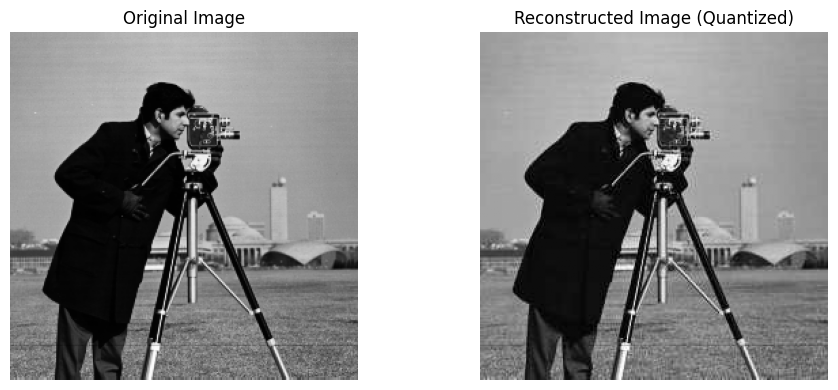

In [8]:
import numpy as np
import cv2
from scipy.fftpack import dct, idct
import matplotlib.pyplot as plt

image = cv2.imread('cameraman.tif', cv2.IMREAD_GRAYSCALE)
if image is None:
    raise FileNotFoundError("Make sure 'cameraman.tif' is in the working directory.")
height, width = image.shape
pad_height = (8 - height % 8) % 8
pad_width = (8 - width % 8) % 8
padded_image = np.pad(image, ((0, pad_height), (0, pad_width)), mode='constant', constant_values=0)

Q = np.array([
    [16, 11, 10, 16, 24, 40, 51, 61],
    [12, 12, 14, 19, 26, 58, 60, 55],
    [14, 13, 16, 24, 40, 57, 69, 56],
    [14, 17, 22, 29, 51, 87, 80, 62],
    [18, 22, 37, 56, 68,109,103, 77],
    [24, 35, 55, 64, 81,104,113, 92],
    [49, 64, 78, 87,103,121,120,101],
    [72, 92, 95, 98,112,100,103, 99]
])

quantized_blocks = np.zeros_like(padded_image, dtype=np.int32)
reconstructed_dct = np.zeros_like(padded_image, dtype=np.float32)
final_reconstructed = np.zeros_like(padded_image, dtype=np.float32)

for i in range(0, padded_image.shape[0], 8):
    for j in range(0, padded_image.shape[1], 8):
        block = padded_image[i:i+8, j:j+8].astype(np.float32) - 128

        dct_block = dct(dct(block.T, norm='ortho').T, norm='ortho')

        q_block = np.round(dct_block / Q).astype(np.int32)
        quantized_blocks[i:i+8, j:j+8] = q_block

        recon_block = q_block * Q
        reconstructed_dct[i:i+8, j:j+8] = recon_block

        idct_block = idct(idct(recon_block.T, norm='ortho').T, norm='ortho')
        final_reconstructed[i:i+8, j:j+8] = idct_block + 128

reconstructed_image = np.clip(final_reconstructed[:height, :width], 0, 255).astype(np.uint8)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(image, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Reconstructed Image (Quantized)")
plt.imshow(reconstructed_image, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()


In [10]:
import numpy as np

def encode_value(val):
    if val == 0:
        return "0"
    elif val == -1:
        return "100"
    elif val == 1:
        return "101"
    elif val == -2:
        return "11000"
    elif val == 2:
        return "11001"
    elif val == -3:
        return "11010"
    elif val == 3:
        return "11011"
    elif val == -4:
        return "1110000"
    elif val == 4:
        return "1110001"
    elif val == -5:
        return "1110010"
    elif val == 5:
        return "1110011"
    elif val == -6:
        return "1110100"
    elif val == 6:
        return "1110101"
    elif val == -7:
        return "1110110"
    elif val == 7:
        return "1110111"
    else:
        return "1111" + format(abs(val), '08b') + ('0' if val < 0 else '1')

def zigzag_scan(block):
    index_order = sorted(((x, y) for x in range(8) for y in range(8)),
                         key=lambda p: (p[0]+p[1], -p[0] if (p[0]+p[1]) % 2 else p[0]))
    return [block[x, y] for x, y in index_order]

bitstream = ""
for i in range(0, quantized_blocks.shape[0], 8):
    for j in range(0, quantized_blocks.shape[1], 8):
        block = quantized_blocks[i:i+8, j:j+8]
        zz = zigzag_scan(block)
        for val in zz:
            bitstream += encode_value(val)

print(f"Total bits in output bitstream: {len(bitstream)}")


Total bits in output bitstream: 108598


In [11]:
import numpy as np
from sklearn.metrics import mean_squared_error

output_size_bits = len(bitstream)

reconstructed_image = np.clip(final_reconstructed[:height, :width], 0, 255).astype(np.uint8)
mse = mean_squared_error(image.flatten(), reconstructed_image.flatten())

original_size_bits = image.size * 8
compression_ratio = original_size_bits / output_size_bits

print(f"Original image size: {original_size_bits} bits")
print(f"Compressed image size: {output_size_bits} bits")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Compression Ratio: {compression_ratio:.2f}")


Original image size: 524288 bits
Compressed image size: 108598 bits
Mean Squared Error (MSE): 43.70
Compression Ratio: 4.83


In [12]:
rounded_blocks = np.zeros_like(padded_image, dtype=np.int32)
reconstructed_dct_rounded = np.zeros_like(padded_image, dtype=np.float32)
final_reconstructed_rounded = np.zeros_like(padded_image, dtype=np.float32)

for i in range(0, padded_image.shape[0], 8):
    for j in range(0, padded_image.shape[1], 8):
        block = padded_image[i:i+8, j:j+8].astype(np.float32) - 128
        dct_block = dct(dct(block.T, norm='ortho').T, norm='ortho')

        rounded_block = np.round(dct_block).astype(np.int32)
        rounded_blocks[i:i+8, j:j+8] = rounded_block

        recon_block = rounded_block.astype(np.float32)
        reconstructed_dct_rounded[i:i+8, j:j+8] = recon_block

        idct_block = idct(idct(recon_block.T, norm='ortho').T, norm='ortho')
        final_reconstructed_rounded[i:i+8, j:j+8] = idct_block + 128

bitstream_rounded = ""
for i in range(0, rounded_blocks.shape[0], 8):
    for j in range(0, rounded_blocks.shape[1], 8):
        block = rounded_blocks[i:i+8, j:j+8]
        zz = zigzag_scan(block)
        for val in zz:
            bitstream_rounded += encode_value(val)

output_size_rounded = len(bitstream_rounded)
reconstructed_image_rounded = np.clip(final_reconstructed_rounded[:height, :width], 0, 255).astype(np.uint8)
mse_rounded = mean_squared_error(image.flatten(), reconstructed_image_rounded.flatten())
compression_ratio_rounded = original_size_bits / output_size_rounded

print("\n[Without Quantization — Just Rounding]")
print(f"Compressed image size: {output_size_rounded} bits")
print(f"Mean Squared Error (MSE): {mse_rounded:.2f}")
print(f"Compression Ratio: {compression_ratio_rounded:.2f}")



[Without Quantization — Just Rounding]
Compressed image size: 411322 bits
Mean Squared Error (MSE): 0.50
Compression Ratio: 1.27


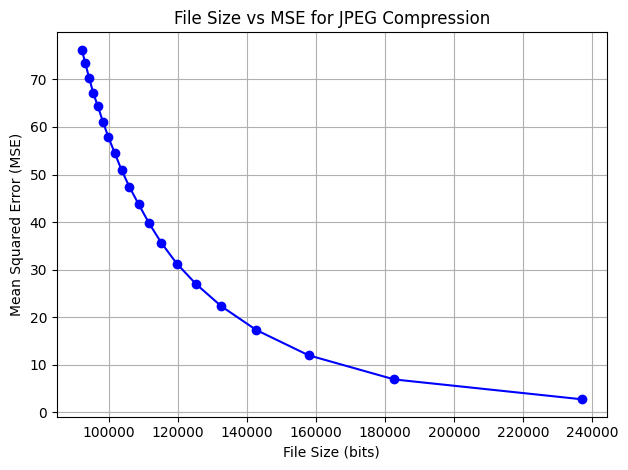

In [14]:
import numpy as np
import cv2
from scipy.fftpack import dct, idct
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

image = cv2.imread('cameraman.tif', cv2.IMREAD_GRAYSCALE)
if image is None:
    raise FileNotFoundError("Make sure 'cameraman.tif' is in the working directory.")

height, width = image.shape
pad_height = (8 - height % 8) % 8
pad_width = (8 - width % 8) % 8
padded_image = np.pad(image, ((0, pad_height), (0, pad_width)), mode='constant', constant_values=0)

Q = np.array([
    [16, 11, 10, 16, 24, 40, 51, 61],
    [12, 12, 14, 19, 26, 58, 60, 55],
    [14, 13, 16, 24, 40, 57, 69, 56],
    [14, 17, 22, 29, 51, 87, 80, 62],
    [18, 22, 37, 56, 68,109,103, 77],
    [24, 35, 55, 64, 81,104,113, 92],
    [49, 64, 78, 87,103,121,120,101],
    [72, 92, 95, 98,112,100,103, 99]
])

def jpeg_compress(image, scale):
    quantized_blocks = np.zeros_like(image, dtype=np.int32)
    reconstructed_dct = np.zeros_like(image, dtype=np.float32)
    final_reconstructed = np.zeros_like(image, dtype=np.float32)

    for i in range(0, image.shape[0], 8):
        for j in range(0, image.shape[1], 8):
            block = image[i:i+8, j:j+8].astype(np.float32) - 128

            dct_block = dct(dct(block.T, norm='ortho').T, norm='ortho')

            q_block = np.round(dct_block / (Q * scale)).astype(np.int32)
            quantized_blocks[i:i+8, j:j+8] = q_block

            recon_block = q_block * (Q * scale)
            reconstructed_dct[i:i+8, j:j+8] = recon_block

            idct_block = idct(idct(recon_block.T, norm='ortho').T, norm='ortho')
            final_reconstructed[i:i+8, j:j+8] = idct_block + 128

    reconstructed_image = np.clip(final_reconstructed[:height, :width], 0, 255).astype(np.uint8)

    mse = mean_squared_error(image.flatten(), reconstructed_image.flatten())

    bitstream = ""
    for i in range(0, quantized_blocks.shape[0], 8):
        for j in range(0, quantized_blocks.shape[1], 8):
            block = quantized_blocks[i:i+8, j:j+8]
            zz = zigzag_scan(block)
            for val in zz:
                bitstream += encode_value(val)

    output_size_bits = len(bitstream)

    return output_size_bits, mse

scales = np.linspace(0.1, 2.0, 20)
file_sizes = []
mse_values = []


for scale in scales:
    file_size, mse = jpeg_compress(padded_image, scale)
    file_sizes.append(file_size)
    mse_values.append(mse)

plt.plot(file_sizes, mse_values, marker='o', linestyle='-', color='b')
plt.title("File Size vs MSE for JPEG Compression")
plt.xlabel("File Size (bits)")
plt.ylabel("Mean Squared Error (MSE)")
plt.grid(True)
plt.tight_layout()
plt.show()
